# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 


## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import f1_score
import spacy
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import wordnet
from tqdm import tqdm
tqdm.pandas(desc='progress')
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()
print(data.duplicated().sum())
display(data.head(10))
display(data['toxic'].value_counts())
print(f"Процент объектов класса 1 к общему объёму датасета: {(sum(data['toxic']) / len(data) * 100):.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
0


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


0    143106
1     16186
Name: toxic, dtype: int64

Процент объектов класса 1 к общему объёму датасета: 10.16%


Пропусков нет, дубликатов нет. Есть дисбаланс классов.

Сделаем предобработку текста:

Очистим комментарии от лишних символов, удалим стоп слова, лемматизируем текст.

In [4]:
def remove_punctuation(text):
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text).lower()
    return clean_text

In [5]:
data['clean'] = data['text'].apply(remove_punctuation)

In [6]:
stop_words = set(stopwords.words('english'))  

In [7]:
def remove_stopwords(text):
    clean_text = ' '.join([word for word in text.split() if not word in stop_words])
    return clean_text
data['stopwords_free'] = data['clean'].apply(remove_stopwords)

In [8]:
nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler"])

In [9]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

In [10]:
data['lemmas'] = data['stopwords_free'].progress_apply(lemmatize_text)

progress: 100%|██████████| 159292/159292 [12:21<00:00, 214.70it/s]


Посмотрим получившийся результат

In [11]:
data.head()

,Unnamed: 0,text,toxic,clean,stopwords_free,lemmas
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m s...,aww matches background colour seemingly stuck ...,aww matches background colour seemingly stuck ...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on im...,make real suggestions improvement wondered sec...,make real suggestions improvement wondered sec...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember...,sir hero chance remember page,sir hero chance remember page


Отфильтруем комментарии в зависимости от того, какую тональность они имеют и визуализируем результат.

In [12]:
data_sampl = data.sample(10000)

In [18]:
normal_word = data_sampl.query('toxic == 0')
normal_word_list = list(normal_word['lemmas'])

toxic_words = data_sampl.query('toxic == 1')
toxic_words_word_list = list(toxic_words['lemmas'])

In [19]:
wordcloud_toxic = WordCloud(max_font_size=50, max_words=150, background_color="black"
                           ).generate(' '.join(w for w in toxic_words_word_list))
wordcloud_normal = WordCloud(max_font_size=50, max_words=100, background_color="black",
                            random_state=123).generate(' '.join(w for w in normal_word_list))

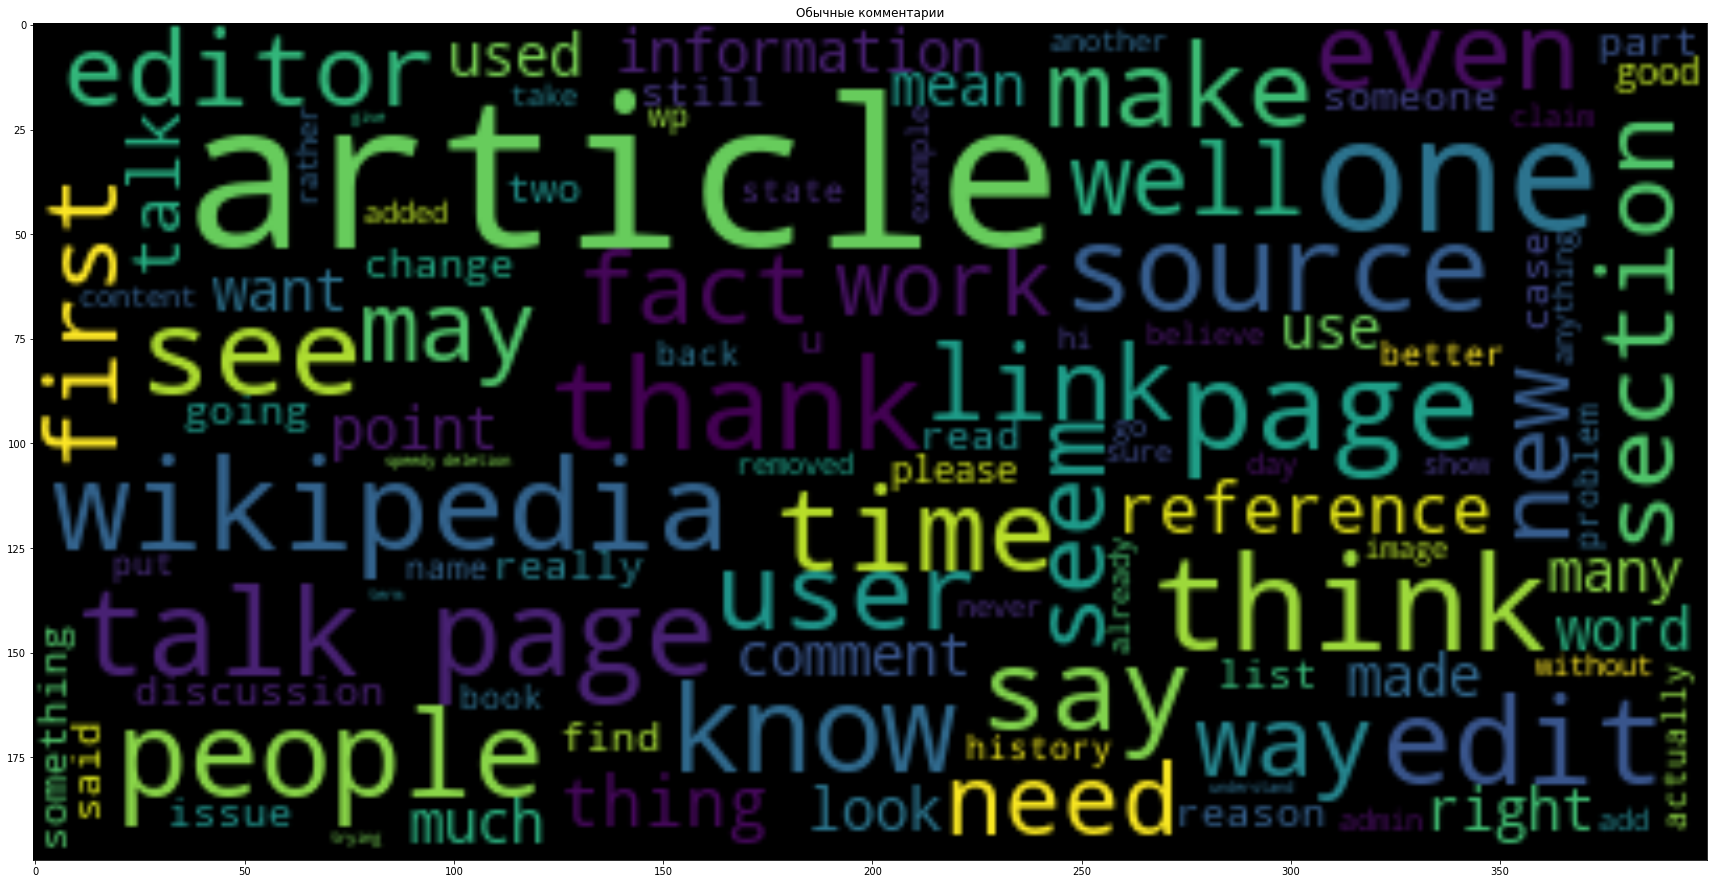

In [16]:
plt.figure(figsize=(30, 20))
plt.title('Обычные комментарии')
plt.imshow(wordcloud_normal, interpolation='bilinear')

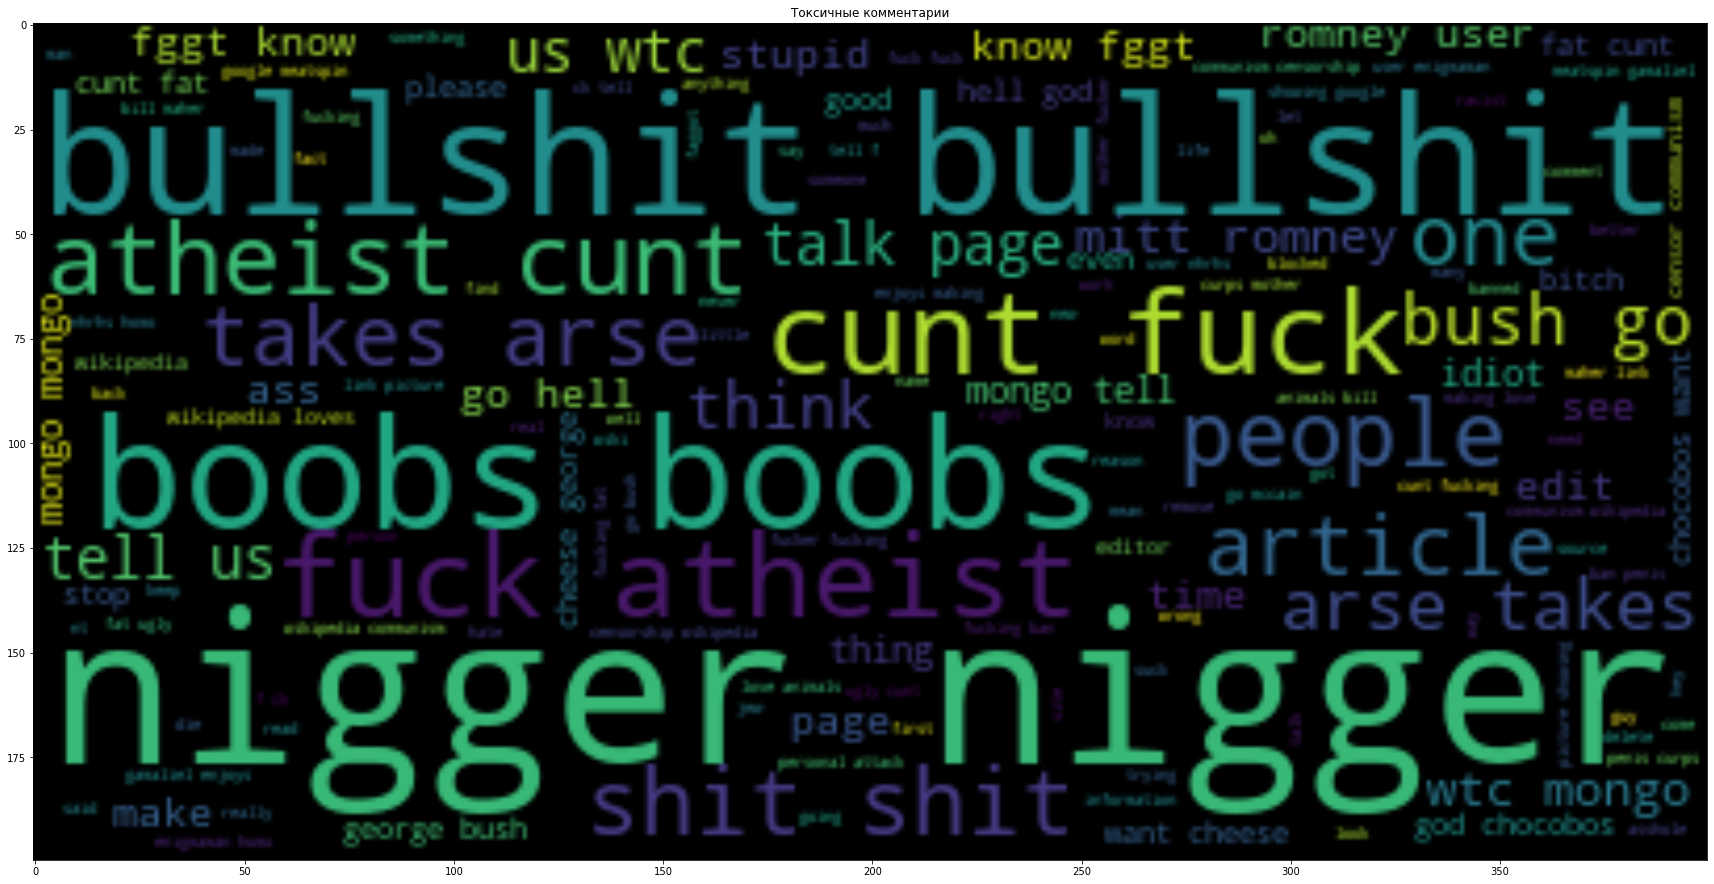

In [17]:
plt.figure(figsize=(30, 20))
plt.title('Токсичные комментарии')
plt.imshow(wordcloud_toxic, interpolation='bilinear')

Подготовим набор данных для обучения моделей.

In [20]:
train, test = train_test_split(data, test_size=0.2, random_state=12345)
features_train = train['lemmas']
target_train = train['toxic']
    
features_test = test['lemmas']
target_test = test['toxic']

Вычислим TF-IDF для корпуса текстов

In [21]:
count_tf_idf = TfidfVectorizer()
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

## Обучение

Начнем с логистической регрессии. 

In [22]:
model = LogisticRegression(class_weight='balanced',random_state=12345)
print('# Train for root_mean_squared_error')
print()
f1_lr = (cross_val_score(model, 
                             features_train_tf, 
                             target_train, 
                             cv=5, 
                             scoring='f1'))
print('f1 =', f1_lr)

# Train for root_mean_squared_error

f1 = [0.7448489  0.75277533 0.75576356 0.75283052 0.75151725]


f1 score > 75

DecisionTreeClassifier

In [23]:
model = DecisionTreeClassifier(class_weight = 'balanced')
max_depth_list = [x for x in range(2, 15)]
hyperparams = [{'max_depth':max_depth_list, 
                'random_state':[12345]}]

In [24]:
clf = GridSearchCV(model, hyperparams, scoring='f1')
clf.fit(features_train_tf, target_train)
print("Наилучшие параметры:")
print(clf.best_params_)
print()
print("f1")
print()
print(clf.best_score_)

Наилучшие параметры:
{'max_depth': 14, 'random_state': 12345}

f1

0.5829027837349438


f1_score меньше 0.75

## Тестирование финальной модели.


In [25]:
model = LogisticRegression(random_state=12345, class_weight='balanced') 
model.fit(features_train_tf, target_train)
predictions = model.predict(features_test_tf)

f1 = f1_score(target_test, predictions)
print('LogisticRegression:', f1)

LogisticRegression: 0.7532854626744343


## Выводы

Выводы:
- данные изучены
- проведена предоброботка текста(Удалены символы и числа, удалены стоп-слова, применена лемматизация)
- После предобработки датафрейм был разделен на обучающую и тестовую выборки
- обучили следующие модели: LogisticRegression, DecisionTreeClassifier. (Самой перспективной представляется логистическая регрессия)

Результат: как наилучшую модель для классификации комментариев можно рекомендовать модель LogisticRegression с гиперпараметром class_weight = 'balanced', которая дает результат F1 = 0.754
